## 1. Introduction to Baby Names Data
<blockquote>
  <p>What’s in a name? That which we call a rose, By any other name would smell as sweet.</p>
</blockquote>
<p>In this project, we will explore a rich dataset of first names of babies born in the US, that spans a period of more than 100 years! This suprisingly simple dataset can help us uncover so many interesting stories, and that is exactly what we are going to be doing. </p>
<p>Let us start by reading the data.</p>

In [125]:
# Import modules
import pandas as pd


# Read names into a dataframe: bnames
bnames = pd.read_csv('datasets/names.csv.gz')

print(bnames.head())

bnames.info()

        name sex  births  year
0       Mary   F    7065  1880
1       Anna   F    2604  1880
2       Emma   F    2003  1880
3  Elizabeth   F    1939  1880
4     Minnie   F    1746  1880
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891894 entries, 0 to 1891893
Data columns (total 4 columns):
name      object
sex       object
births    int64
year      int64
dtypes: int64(2), object(2)
memory usage: 57.7+ MB


## 2. Exploring Trends in Names
<p>One of the first things we want to do is to understand naming trends. Let us start by figuring out the top five most popular male and female names for this decade (born 2011 and later). Do you want to make any guesses? Go on, be a sport!!</p>

In [127]:
# bnames_top5: A dataframe with top 5 popular male and female names for the decade
#select only yearsin this decade
this_decade = bnames.loc[(bnames.year > 2010)]
#sum up how many babies were born in this decade wtih each name for each gender
name_counts = this_decade.groupby(['sex', 'name'], 
                                  as_index=False)['births'].sum()
#sort and select only the top 5 names for each gender
bnames_top5 = name_counts.sort_values(
    ['sex', 'births'], ascending=[True, False]).groupby(
    'sex').head().reset_index(drop=True)

print(bnames_top5)



  sex      name  births
0   F      Emma  121375
1   F    Sophia  117352
2   F    Olivia  111691
3   F  Isabella  103947
4   F       Ava   94507
5   M      Noah  110280
6   M     Mason  105104
7   M     Jacob  104722
8   M      Liam  103250
9   M   William   99144


## 3. Proportion of Births
<p>While the number of births is a useful metric, making comparisons across years becomes difficult, as one would have to control for population effects. One way around this is to normalize the number of births by the total number of births in that year.</p>

In [129]:
bnames2 = bnames.copy()
# Compute the proportion of births by year and add it as a new column

#dreate a dictionary of total number of births for each year
groupby_year = bnames.groupby(['year'])['births']
births_per_year_dict = {year:group.sum() for year,group in groupby_year}

#create an iterable with years and births
zipped_year_births = zip(bnames2.year, bnames2.births)
#initialize a list to hold all the calculated birth proportions
prop_births = []
#iterate over the zip object to calculate proportion for each name using the birth totals from the dictionary
for year, births in zipped_year_births:
    prop_births.append(births/births_per_year_dict[year])
#assign the list of proportions to the new column 'prop_births' in bnames2 
bnames2['prop_births'] = prop_births    
print(bnames2)




              name sex  births  year  prop_births
0             Mary   F    7065  1880     0.035065
1             Anna   F    2604  1880     0.012924
2             Emma   F    2003  1880     0.009941
3        Elizabeth   F    1939  1880     0.009624
4           Minnie   F    1746  1880     0.008666
5         Margaret   F    1578  1880     0.007832
6              Ida   F    1472  1880     0.007306
7            Alice   F    1414  1880     0.007018
8           Bertha   F    1320  1880     0.006551
9            Sarah   F    1288  1880     0.006393
10           Annie   F    1258  1880     0.006244
11           Clara   F    1226  1880     0.006085
12            Ella   F    1156  1880     0.005737
13        Florence   F    1063  1880     0.005276
14            Cora   F    1045  1880     0.005187
15          Martha   F    1040  1880     0.005162
16           Laura   F    1012  1880     0.005023
17          Nellie   F     995  1880     0.004938
18           Grace   F     982  1880     0.004874


## 4. Popularity of Names
<p>Now that we have the proportion of births, let us plot the popularity of a name through the years. How about plotting the popularity of the female names <code>Elizabeth</code>, and <code>Deneen</code>, and inspecting the underlying trends for any interesting patterns!</p>

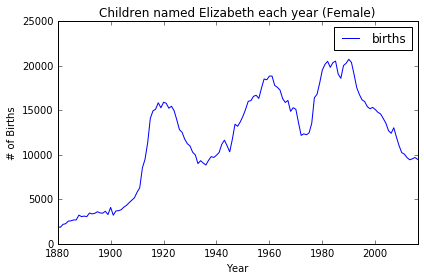

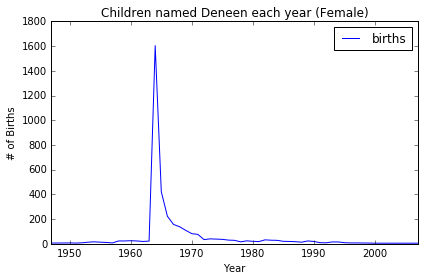

In [146]:
# Set up matplotlib for plotting in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt

def plot_trends(name, sex):
  """using the provided name and sex, plot number of births by year"""
  births_by_name = bnames2.loc[(bnames2['name']==name) & (bnames2['sex']==sex)]
  births_by_name.plot('year', 'births')
  plt.xlabel('Year')
  plt.ylabel('# of Births')
  g_map = {'M':'Male', 'F':'Female'}
  plt.title('Children named ' + name + ' each year ' + "(" + g_map[sex] +")")
  return


# Plot trends for Elizabeth and Deneen 
plot_trends('Elizabeth', 'F')
plot_trends('Deneen', 'F')

    
# How many times did these female names peak?
num_peaks_elizabeth = 3
num_peaks_deneen    = 1

## 5. Trendy vs. Stable Names
<p>Based on the plots we created earlier, we can see that <strong>Elizabeth</strong> is a fairly stable name, while <strong>Deneen</strong> is not. An interesting question to ask would be what are the top 5 stable and top 5 trendiest names. A stable name is one whose proportion across years does not vary drastically, while a trendy name is one whose popularity peaks for a short period and then dies down. </p>
<p>There are many ways to measure trendiness. A simple measure would be to look at the maximum proportion of births for a name, normalized by the sume of proportion of births across years. For example, if the name <code>Joe</code> had the proportions <code>0.1, 0.2, 0.1, 0.1</code>, then the trendiness measure would be <code>0.2/(0.1 + 0.2 + 0.1 + 0.1)</code> which equals <code>0.5</code>.</p>
<p>Let us use this idea to figure out the top 10 trendy names in this data set, with at least a 1000 births.</p>

In [133]:
# top10_trendy_names | A Data Frame of the top 10 most trendy names
def total(series):
    """Rename sum to total for ease of reporting"""
    value = sum(series)
    return value

#find total and max number of births for each name/gender combination
births_by_name = bnames.groupby(['name', 'sex'], 
                                as_index=False)['births'].agg([total, 'max'])

#generate the new trendiness column
births_by_name['trendiness'] = (births_by_name['max'] /
                                births_by_name['total'])
print(births_by_name.shape)
#filter out only those names with over 1000 births
births_by_name= births_by_name.loc[births_by_name['total'] >= 1000]
#sort and find the top 10 most trendy names
top10_trendy_names = births_by_name.sort_values(
    'trendiness', ascending=False).head(10).reset_index()

print(top10_trendy_names)

(106695, 3)
       name sex  total   max  trendiness
0  Christop   M   1082  1082    1.000000
1   Royalty   F   1057   581    0.549669
2     Kizzy   F   2325  1116    0.480000
3    Aitana   F   1203   564    0.468828
4    Deneen   F   3602  1604    0.445308
5    Moesha   F   1067   426    0.399250
6    Marely   F   2527  1004    0.397309
7     Kanye   M   1304   507    0.388804
8  Tennille   F   2172   769    0.354052
9   Kadijah   F   1411   486    0.344437


## 6. Bring in Mortality Data
<p>So, what more is in a name? Well, with some further work, it is possible to predict the age of a person based on the name (Whoa! Really????). For this, we will need actuarial data that can tell us the chances that someone is still alive, based on when they were born. Fortunately, the <a href="https://www.ssa.gov/">SSA</a> provides detailed <a href="https://www.ssa.gov/oact/STATS/table4c6.html">actuarial life tables</a> by birth cohorts.</p>
<table>
<thead>
<tr>
<th style="text-align:right;">year</th>
<th style="text-align:right;">age</th>
<th style="text-align:right;">qx</th>
<th style="text-align:right;">lx</th>
<th style="text-align:right;">dx</th>
<th style="text-align:right;">Lx</th>
<th style="text-align:right;">Tx</th>
<th style="text-align:right;">ex</th>
<th style="text-align:left;">sex</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">39</td>
<td style="text-align:right;">0.00283</td>
<td style="text-align:right;">78275</td>
<td style="text-align:right;">222</td>
<td style="text-align:right;">78164</td>
<td style="text-align:right;">3129636</td>
<td style="text-align:right;">39.98</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">40</td>
<td style="text-align:right;">0.00297</td>
<td style="text-align:right;">78053</td>
<td style="text-align:right;">232</td>
<td style="text-align:right;">77937</td>
<td style="text-align:right;">3051472</td>
<td style="text-align:right;">39.09</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">41</td>
<td style="text-align:right;">0.00318</td>
<td style="text-align:right;">77821</td>
<td style="text-align:right;">248</td>
<td style="text-align:right;">77697</td>
<td style="text-align:right;">2973535</td>
<td style="text-align:right;">38.21</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">42</td>
<td style="text-align:right;">0.00332</td>
<td style="text-align:right;">77573</td>
<td style="text-align:right;">257</td>
<td style="text-align:right;">77444</td>
<td style="text-align:right;">2895838</td>
<td style="text-align:right;">37.33</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">43</td>
<td style="text-align:right;">0.00346</td>
<td style="text-align:right;">77316</td>
<td style="text-align:right;">268</td>
<td style="text-align:right;">77182</td>
<td style="text-align:right;">2818394</td>
<td style="text-align:right;">36.45</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">44</td>
<td style="text-align:right;">0.00351</td>
<td style="text-align:right;">77048</td>
<td style="text-align:right;">270</td>
<td style="text-align:right;">76913</td>
<td style="text-align:right;">2741212</td>
<td style="text-align:right;">35.58</td>
<td style="text-align:left;">F</td>
</tr>
</tbody>
</table>
<p>You can read the <a href="https://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html">documentation for the lifetables</a> to understand what the different columns mean. The key column of interest to us is <code>lx</code>, which provides the number of people born in a <code>year</code> who live upto a given <code>age</code>. The probability of being alive can be derived as <code>lx</code> by 100,000. </p>
<p>Given that 2016 is the latest year in the baby names dataset, we are interested only in a subset of this data, that will help us answer the question, "What percentage of people born in Year X are still alive in 2016?" </p>
<p>Let us use this data and plot it to get a sense of the mortality distribution!</p>

      year  age       qx       lx     dx      Lx         Tx     ex sex
116   1900  116  0.83363      0.0      0       0          0   0.69   M
236   1900  116  0.83363      0.0      0       0          0   0.69   F
346   1910  106  0.51178      7.0      3       5          9   1.38   M
466   1910  106  0.47062     61.0     29      47         92   1.52   F
576   1920   96  0.30765   1625.0    500   1,375      4,000   2.46   M
696   1920   96  0.25681   5428.0  1,394   4,731     15,788   2.91   F
806   1930   86  0.12620  20766.0  2,621  19,455    105,149   5.06   M
926   1930   86  0.09239  35078.0  3,241  33,458    216,619   6.18   F
1036  1940   76  0.04469  52262.0  2,336  51,094    527,017  10.08   M
1156  1940   76  0.03168  65417.0  2,072  64,380    783,771  11.98   F
1266  1950   66  0.01825  74633.0  1,362  73,952  1,261,965  16.91   M
1386  1950   66  0.01268  83676.0  1,061  83,145  1,631,592  19.50   F
1496  1960   56  0.00708  85491.0    605  85,188  2,162,629  25.30   M
1616  

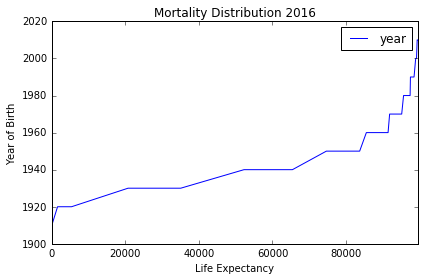

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Read lifetables from datasets/lifetables.csv
lifetables = pd.read_csv('datasets/lifetables.csv')
#print(lifetables)

# Extract subset relevant to those alive in 2016
lifetables_2016 = lifetables.loc[
    (lifetables['year']+lifetables['age']) == 2016]
print(lifetables_2016)

# Plot the mortality distribution: year vs. lx
lifetables_2016.plot('lx', 'year')
plt.xlabel('Life Expectancy')
plt.ylabel('Year of Birth')
plt.title('Mortality Distribution 2016')
plt.show()


## 7. Smoothen the Curve!
<p>We are almost there. There is just one small glitch. The cohort life tables are provided only for every decade. In order to figure out the distribution of people alive, we need the probabilities for every year. One way to fill up the gaps in the data is to use some kind of interpolation. Let us keep things simple and use linear interpolation to fill out the gaps in values of <code>lx</code>, between the years <code>1900</code> and <code>2016</code>.</p>

In [137]:
# Create smoothed lifetable_2016_s by interpolating values of lx
#make a data frame with all the years 1900-2016
lifetable_2016_f = pd.DataFrame({'year': [i for i in range(1900, 2016)]})
#split off just the female data
lx_f = lifetables_2016.loc[lifetables_2016.sex == 'F']
#merge the year df with the female data 
f_lx_2016 = pd.merge_ordered(
    lifetable_2016_f, lx_f, on='year')
#interpolate values of lx linearly
f_lx_2016.lx.interpolate(method='linear', inplace=True)
#fill in missing values in the gender column
f_lx_2016['sex'] = 'F'

#repeat the above steps on the male rows
lifetable_2016_m = pd.DataFrame({'year': [i for i in range(1900,2016)]})
lx_m = lifetables_2016.loc[lifetables_2016.sex == 'M']
m_lx_2016 = pd.merge_ordered(
    lifetable_2016_m, lx_m, on='year')
m_lx_2016.lx.interpolate(method='linear', inplace=True)
m_lx_2016['sex'] = 'M'

#append the male df to the female
lifetable_2016_s = f_lx_2016.append(m_lx_2016)
#select only the columns of interest
lifetable_2016_s = lifetable_2016_s.loc[:, ['lx', 'sex', 'year']]
print(lifetable_2016_s)


          lx sex  year
0        0.0   F  1900
1        6.1   F  1901
2       12.2   F  1902
3       18.3   F  1903
4       24.4   F  1904
5       30.5   F  1905
6       36.6   F  1906
7       42.7   F  1907
8       48.8   F  1908
9       54.9   F  1909
10      61.0   F  1910
11     597.7   F  1911
12    1134.4   F  1912
13    1671.1   F  1913
14    2207.8   F  1914
15    2744.5   F  1915
16    3281.2   F  1916
17    3817.9   F  1917
18    4354.6   F  1918
19    4891.3   F  1919
20    5428.0   F  1920
21    8393.0   F  1921
22   11358.0   F  1922
23   14323.0   F  1923
24   17288.0   F  1924
25   20253.0   F  1925
26   23218.0   F  1926
27   26183.0   F  1927
28   29148.0   F  1928
29   32113.0   F  1929
..       ...  ..   ...
86   96718.2   M  1986
87   96904.9   M  1987
88   97091.6   M  1988
89   97278.3   M  1989
90   97465.0   M  1990
91   97607.3   M  1991
92   97749.6   M  1992
93   97891.9   M  1993
94   98034.2   M  1994
95   98176.5   M  1995
96   98318.8   M  1996
97   98461.

## 8. Distribution of People Alive by Name
<p>Now that we have all the required data, we need a few helper functions to help us with our analysis. </p>
<p>The first function we will write is <code>get_data</code>,which takes <code>name</code> and <code>sex</code> as inputs and returns a data frame with the distribution of number of births and number of people alive by year.</p>
<p>The second function is <code>plot_name</code> which accepts the same arguments as <code>get_data</code>, but returns a line plot of the distribution of number of births, overlaid by an area plot of the number alive by year.</p>
<p>Using these functions, we will plot the distribution of births for boys named <strong>Joseph</strong> and girls named <strong>Brittany</strong>.</p>

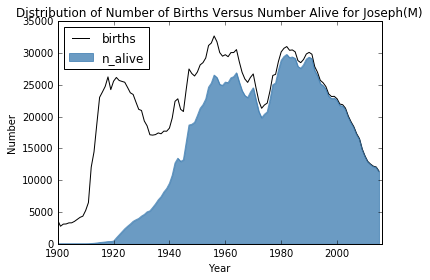

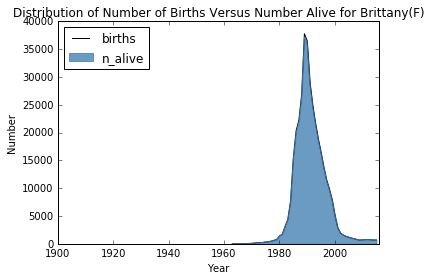

In [139]:
def get_data(name, sex):
    """generate a dataframe with the merged life 
    expectancy information with the birth information 
    for a given name/gender combination"""
    name_df = pd.merge(
        bnames.loc[(bnames['name']==name) & (bnames['sex']==sex)], 
        lifetable_2016_s, on=['year', 'sex'])
    name_df['n_alive'] = name_df['lx'] * name_df['births'] / 100000
    return name_df
    

def plot_data(name, sex):
    """Plots the Distribution of number of births versus number alive """
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots()
    data = get_data(name, sex)
    data.plot('year', 'births', color='black', ax=ax)
    data.plot('year', 'n_alive', kind='area', color='steelblue', ax=ax, alpha=0.8)
    plt.xlabel('Year')
    plt.ylabel('Number')
    plt.title('Distribution of Number of Births Versus Number Alive for '
              + name +"(" + sex + ")")
    ax.set_xlim(1900,2016)
    plt.show()
    return 
    
# Plot the distribution of births and number alive for Joseph and Brittany
plot_data('Joseph', 'M')
plot_data('Brittany', 'F')


## 9. Estimate Age
<p>In this section, we want to figure out the probability that a person with a certain name is alive, as well as the quantiles of their age distribution. In particular, we will estimate the age of a female named <strong>Gertrude</strong>. Any guesses on how old a person with this name is? How about a male named <strong>William</strong>?</p>

In [141]:
# Import modules
from wquantiles import quantile

# Function to estimate age quantiles
def estimate_age(name, sex):
    """Get summary statistics on estimate agefor a given name/gender combination"""
    #Retrieve a dataframe with life expectancy info
    d = get_data(name, sex)
    
    #Fin the current age for each birth year
    d['current_age'] = 2016 - d['year']
    #Calculate the probability an individual with the name is alive in 2016
    p_alive = d.n_alive.sum()/d.births.sum()
    #Calculate Average Age for an indiviual with the name -used for test purposes -not reported
    av_age = (d.n_alive * d.current_age).sum()/ d.n_alive.sum()
    #calculate the quartiles - weighting current age by number of those individuals alive
    q1 = quantile(d.current_age, d.n_alive, .25)
    q2 = quantile(d.current_age, d.n_alive, .5)
    q3 = quantile(d.current_age, d.n_alive, .75)
    #create a series of the calculated values
    series = pd.Series([name, p_alive, q1, q2, q3, sex], 
                       index= ['name', 'p_alive', 'q25', 'q50', 'q75', 'sex'])

    return series

# Estimate the age of Gertrude
estimate_age('Gertrude', 'F')

name       Gertrude
p_alive    0.187256
q25         69.0775
q50         79.9437
q75         88.4885
sex               F
dtype: object

## 10. Median Age of Top 10 Female Names
<p>In the previous section, we estimated the age of a female named Gertrude. Let's go one step further this time, and compute the 25th, 50th and 75th percentiles of age, and the probability of being alive for the top 10 most common female names of all time. This should give us some interesting insights on how these names stack up in terms of median ages!</p>

In [143]:
# Create median_ages: DataFrame with Top 10 Female names, 
#    age percentiles and probability of being alive
#find total births for each name/gender combination
extract = bnames.groupby(['name', 'sex'], as_index=False)['births'].sum()
#select only female names
extract = extract.loc[extract['sex'] == 'F']
#sort by number of births, most first, and select only the top 10
extract = extract.sort_values(
    'births', ascending=False).head(10).reset_index()

print(extract)

#run the estimate_age function for each of the top10 names
series_list = [estimate_age(n, s) for n,s in zip(extract['name'],extract['sex'])]

#create a df from the estimate_age results
median_ages = pd.DataFrame(series_list)

print(median_ages)





   index       name sex   births
0  67099       Mary   F  4120692
1  30037  Elizabeth   F  1620611
2  77362   Patricia   F  1571380
3  45514   Jennifer   F  1465243
4  61513      Linda   F  1451809
5  11329    Barbara   F  1433727
6  65802   Margaret   F  1244388
7  92420      Susan   F  1121148
8  27966    Dorothy   F  1106575
9  85548      Sarah   F  1069797
        name   p_alive        q25        q50        q75 sex
0       Mary  0.544080  52.980412  63.513551  73.755795   F
1  Elizabeth  0.744920  22.757173  37.801482  57.517297   F
2   Patricia  0.767523  53.895009  62.688668  70.010346   F
3   Jennifer  0.963536  30.817393  37.482561  43.599117   F
4      Linda  0.834324  56.619648  63.576777  68.101376   F
5    Barbara  0.706063  57.755453  65.975158  73.537393   F
6   Margaret  0.494679  50.187733  63.866447  74.448792   F
7      Susan  0.857993  51.587657  58.505283  64.552512   F
8    Dorothy  0.358119  63.316073  74.169920  84.224271   F
9      Sarah  0.860528  19.941632  29